# Section 1

Analyses for Section 1 of the Manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML"
df = pd.read_csv(base_p / "closed_performance.tsv", sep='\t')
df.head()

task       acc  recall  precision        f1
0   HIGH_VS_95LOW__3VRL__auto__0__42  0.996600  0.9980   0.995213  0.996605
1  HIGH_VS_LOOSER__3VRL__auto__0__42  0.953400  0.9604   0.947140  0.953724
2     ONE_VS_NINE__3VRL__auto__0__42  0.972986  0.9750   0.971116  0.973054
3   HIGH_VS_95LOW__3VRL__auto__1__42  0.996200  0.9986   0.993830  0.996209
4  HIGH_VS_LOOSER__3VRL__auto__1__42  0.952600  0.9576   0.948119  0.952836

In [3]:
records = []
for i, row in df.iterrows():
    task_str = row["task"]
    task = datasets.ClassificationTask.init_from_str(task_str)
    records.append({
        "task": task_str,
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "task_type": task.task_type.to_str(),
    })

df = pd.merge(df, pd.DataFrame(records), on="task")

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
df["task_type_clean"] = df["task_type"].map(map_task_type_to_clean)
df["acc_closed"] = df["acc"].astype(float)

print(df.shape)
df.head()

(1080, 12)


task       acc  recall  precision        f1  \
0   HIGH_VS_95LOW__3VRL__auto__0__42  0.996600  0.9980   0.995213  0.996605   
1  HIGH_VS_LOOSER__3VRL__auto__0__42  0.953400  0.9604   0.947140  0.953724   
2     ONE_VS_NINE__3VRL__auto__0__42  0.972986  0.9750   0.971116  0.973054   
3   HIGH_VS_95LOW__3VRL__auto__1__42  0.996200  0.9986   0.993830  0.996209   
4  HIGH_VS_LOOSER__3VRL__auto__1__42  0.952600  0.9576   0.948119  0.952836   

  ag_pos ag_neg  seed_id  split_id       task_type task_type_clean  acc_closed  
0   3VRL   auto        0        42   high_vs_95low   vs Non-binder    0.996600  
1   3VRL   auto        0        42  high_vs_looser         vs Weak    0.953400  
2   3VRL   auto        0        42             1v9            vs 9    0.972986  
3   3VRL   auto        1        42   high_vs_95low   vs Non-binder    0.996200  
4   3VRL   auto        1        42  high_vs_looser         vs Weak    0.952600

## vs Non-binder, vs Weak, vs 1, vs 9 performances

In [4]:
# Get order of antigens by high_vs_looser performance
ag_order = df.loc[df["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

In [5]:
task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
task_clean_order = [map_task_type_to_clean[x] for x in task_order]

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_29293/1491976713.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


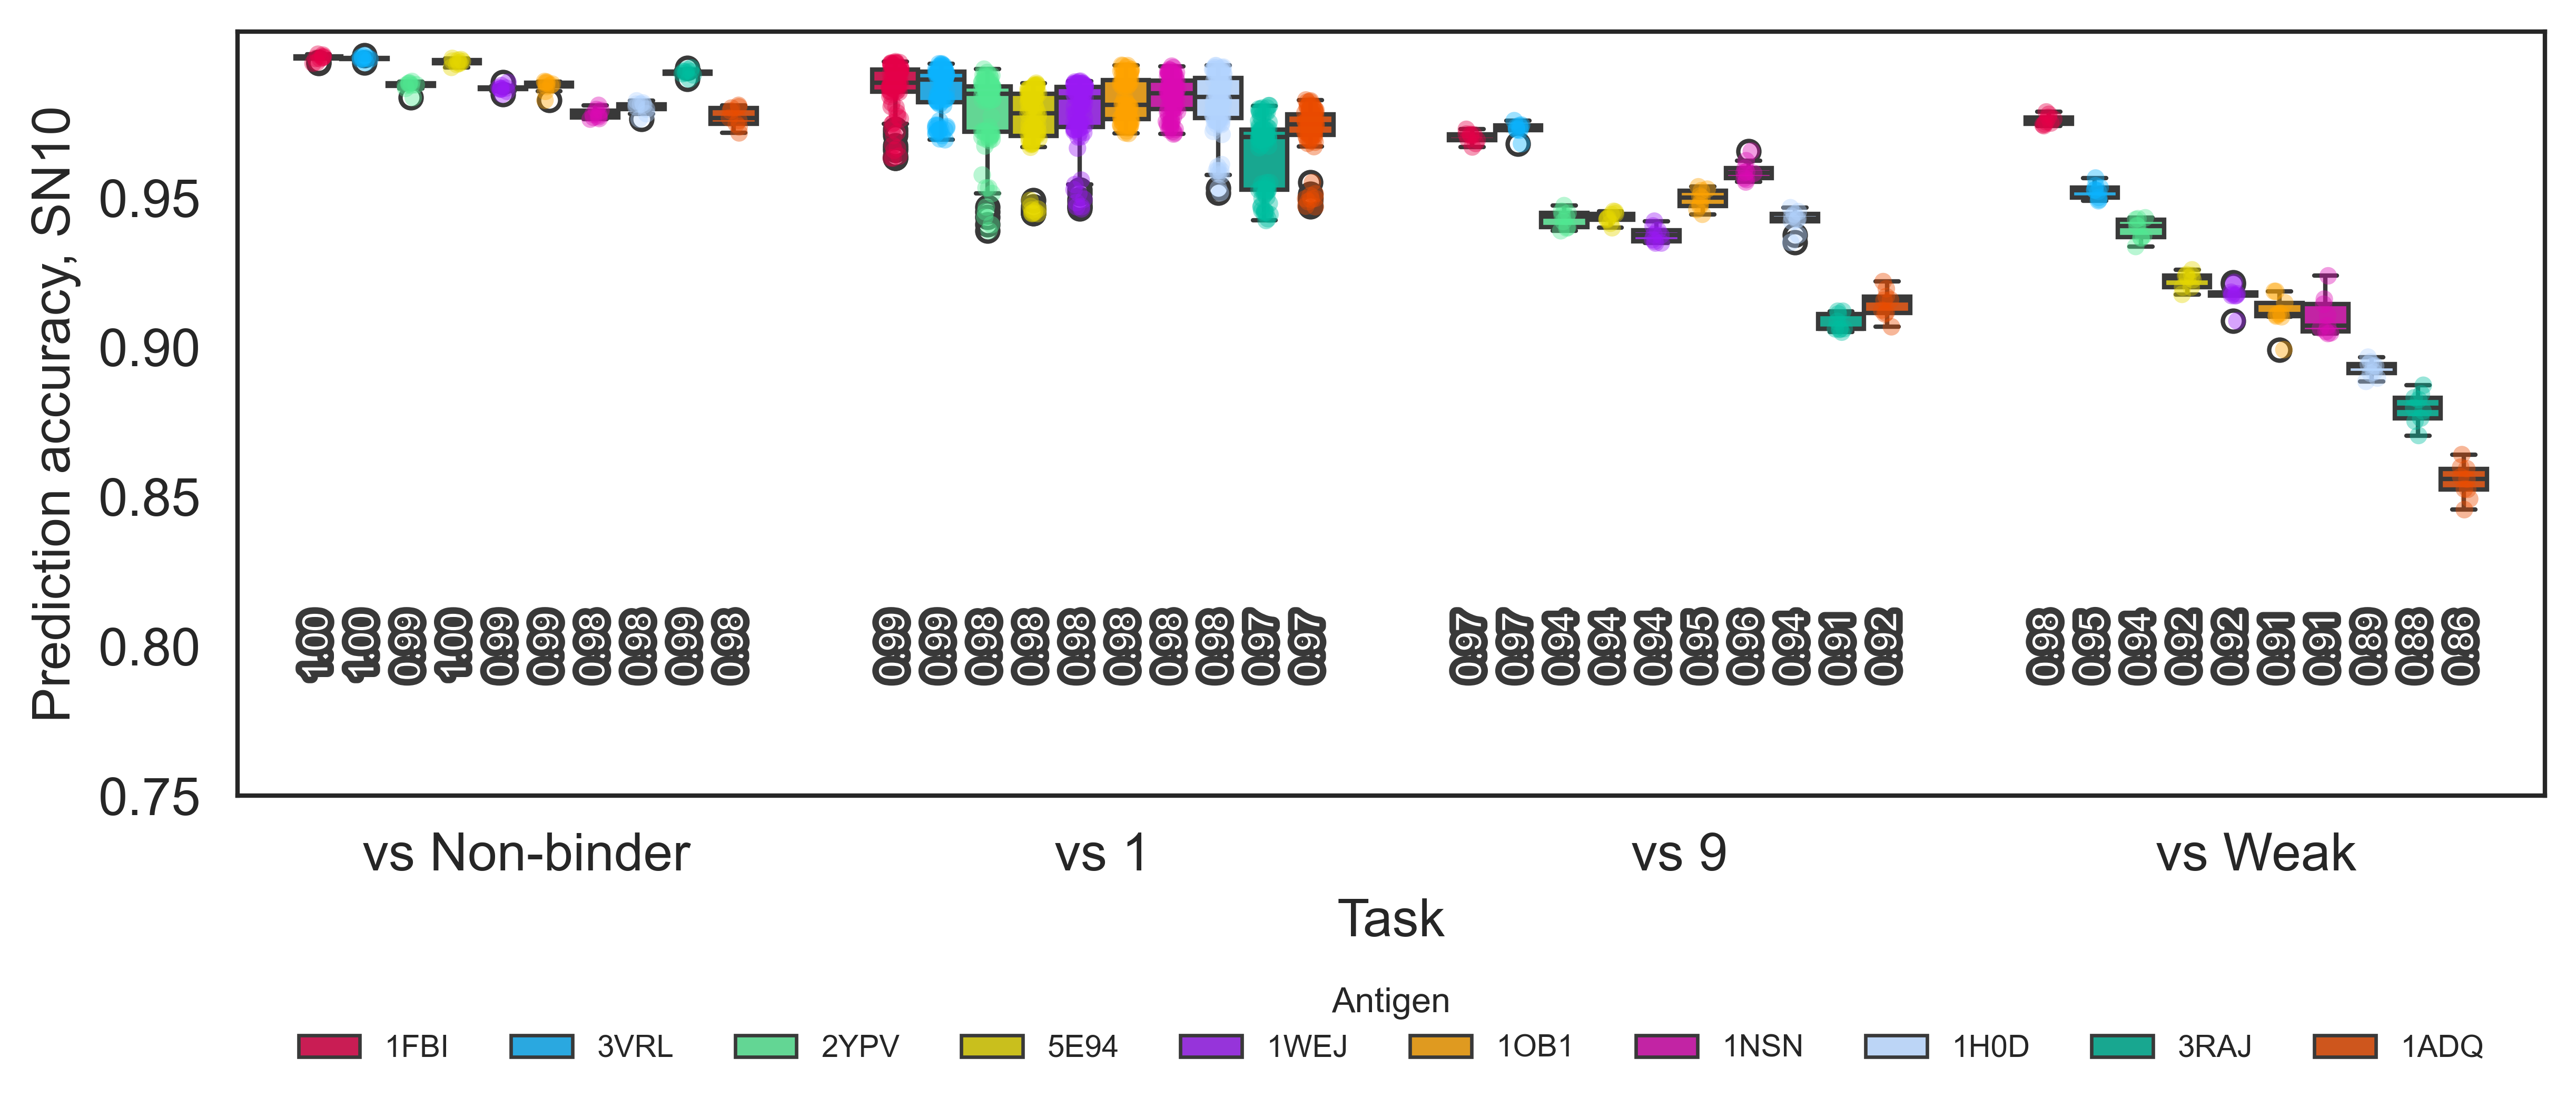

In [6]:
yticks = np.arange(0.75, 1.0, 0.05)
yaxis_title = "Prediction accuracy, SN10"
ag_order = visualisations.PlotParams.order_antigens
task_order = visualisations.PlotParams.order_tasks
task_clean_order = visualisations.PlotParams.order_tasks_clean
cmap = visualisations.PlotParams.cmap_antigens

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.boxplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    boxprops=dict(alpha=1),
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

visualisations.add_median_labels(ax, y_level=0.8, fontsize=8)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel(yaxis_title, fontsize=12)
ax.set_yticks(yticks)

fig.show()

In [7]:
df.groupby("task_type")["acc_closed"].agg(["mean", "std"])

mean       std
task_type                         
1v1             0.979155  0.011871
1v9             0.944077  0.020250
high_vs_95low   0.987700  0.007301
high_vs_looser  0.915720  0.033752

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_29293/2047051091.py:9: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_29293/2047051091.py:26: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_29293/2047051091.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


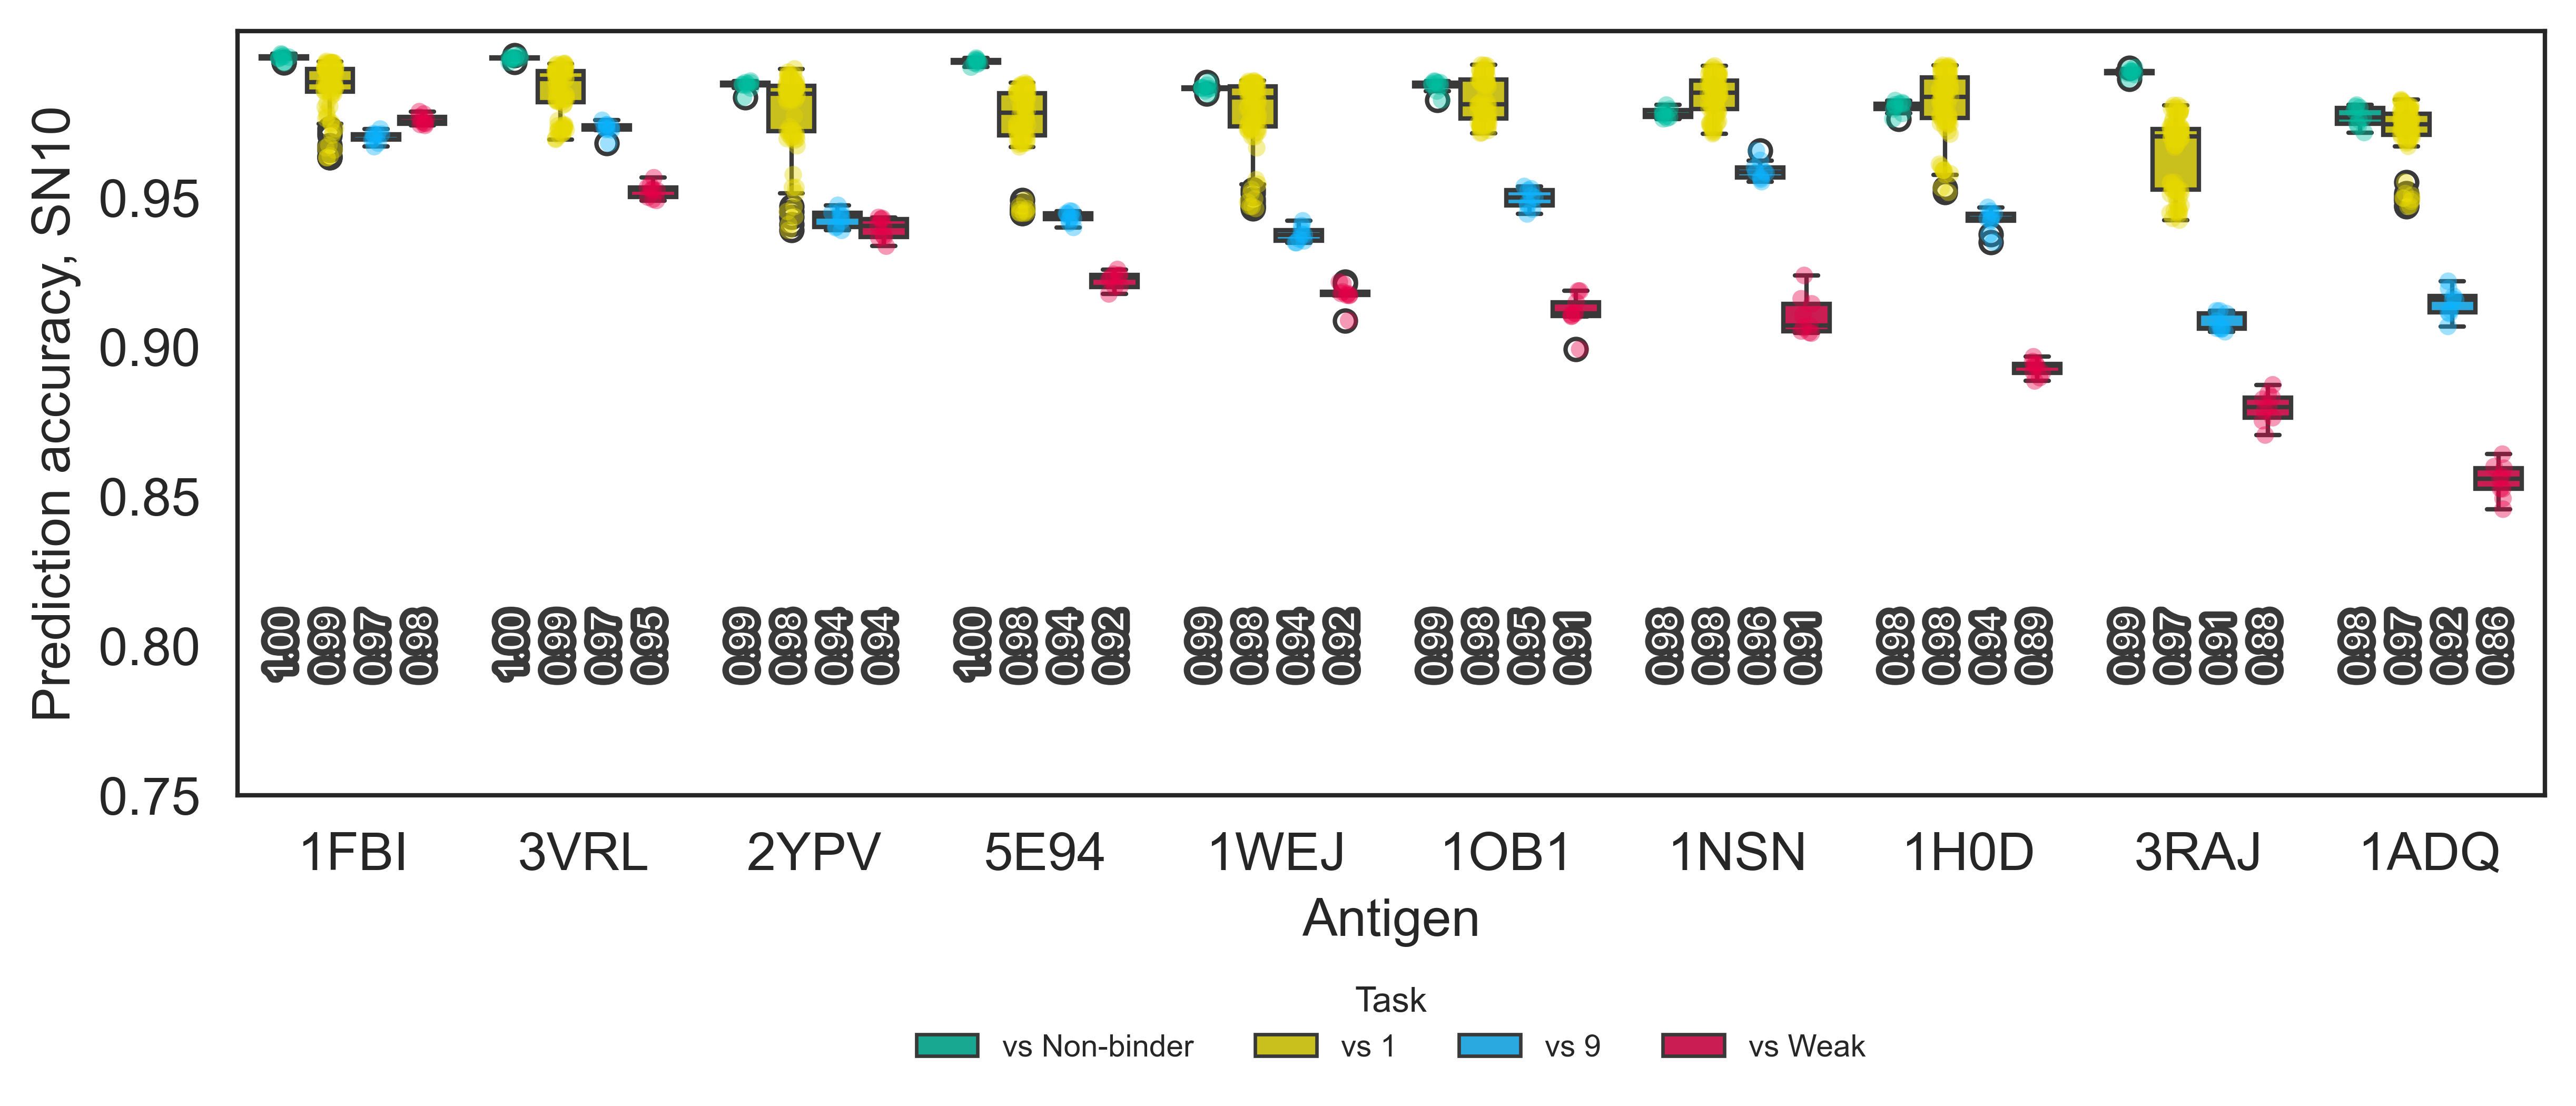

In [8]:
cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)


## Add data points on top of boxplot in low transparency
sns.stripplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    # Order on x axis
    order=ag_order,
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    # palette="Set2",
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    order=ag_order,
    boxprops=dict(alpha=1),  # a better solution is below
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    palette=cmap,
)
## Based on https://github.com/mwaskom/seaborn/issues/979#issuecomment-235082271
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.1))


visualisations.add_median_labels(ax, y_level=0.8, fontsize=8)


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)

ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)
# Add legend under the plot, under x axis label
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

fig.show()

In [9]:
df.groupby("ag_pos")["acc_closed"].agg(["mean", "std"]).sort_values("mean", ascending=False)

mean       std
ag_pos                    
1FBI    0.985321  0.009709
3VRL    0.982775  0.012571
1NSN    0.975461  0.021716
1OB1    0.974594  0.022260
2YPV    0.973389  0.018590
1H0D    0.970723  0.027589
1WEJ    0.970656  0.022375
5E94    0.969828  0.020931
1ADQ    0.958215  0.036043
3RAJ    0.955612  0.031001

## Entropy of slides

In [10]:
from NegativeClassOptimization.utils import jensen_shannon_divergence_slides 

# Compute JSD for each task
# Note: takes a few minutes
loader = datasets.FrozenMiniAbsolutMLLoader(base_p)
jsds = []
for task_str in df["task"]:
    task = datasets.ClassificationTask.init_from_str(task_str)
    
    try:
        loader.load(task, load_model=False)
    except:
        print(f"Failed to load {task_str}")
        raise

    slides_neg = task.test_dataset.query("binds_a_pos_ag == 0")["Slide"].to_list() # type: ignore
    slides_pos = task.test_dataset.query("binds_a_pos_ag == 1")["Slide"].to_list() # type: ignore
    jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
    jsds.append(jsd)
df["jsd"] = jsds

### Beginning or temp analysis

In [12]:
pd_logit_rule = pd.read_csv('/Users/aygulminnegalieva/Music/nco/negative-class-optimization/data/07e_LogitEnergyCorrelations.tsv', sep='\t')

In [32]:
df_merged = df.merge(pd_logit_rule, on = ['task_type', 'ag_pos', 'ag_neg', 'seed_id', 'split_id'])

In [36]:
df_merged.columns

Index(['task', 'acc', 'recall', 'precision', 'f1', 'ag_pos', 'ag_neg',
       'seed_id', 'split_id', 'task_type', 'task_type_clean', 'acc_closed',
       'jsd', 'r', 'p', 'r2', 'r_pos', 'r_pos2', 'p_pos', 'slope', 'intercept',
       'slope_pos', 'intercept_pos', 'logits_mean', 'logits_std',
       'Energy_mean', 'Energy_std', 'logits_pos_mean', 'logits_pos_std',
       'Energy_pos_mean', 'Energy_pos_std', 'logits_neg_mean',
       'logits_neg_std', 'Energy_neg_mean', 'Energy_neg_std'],
      dtype='object')

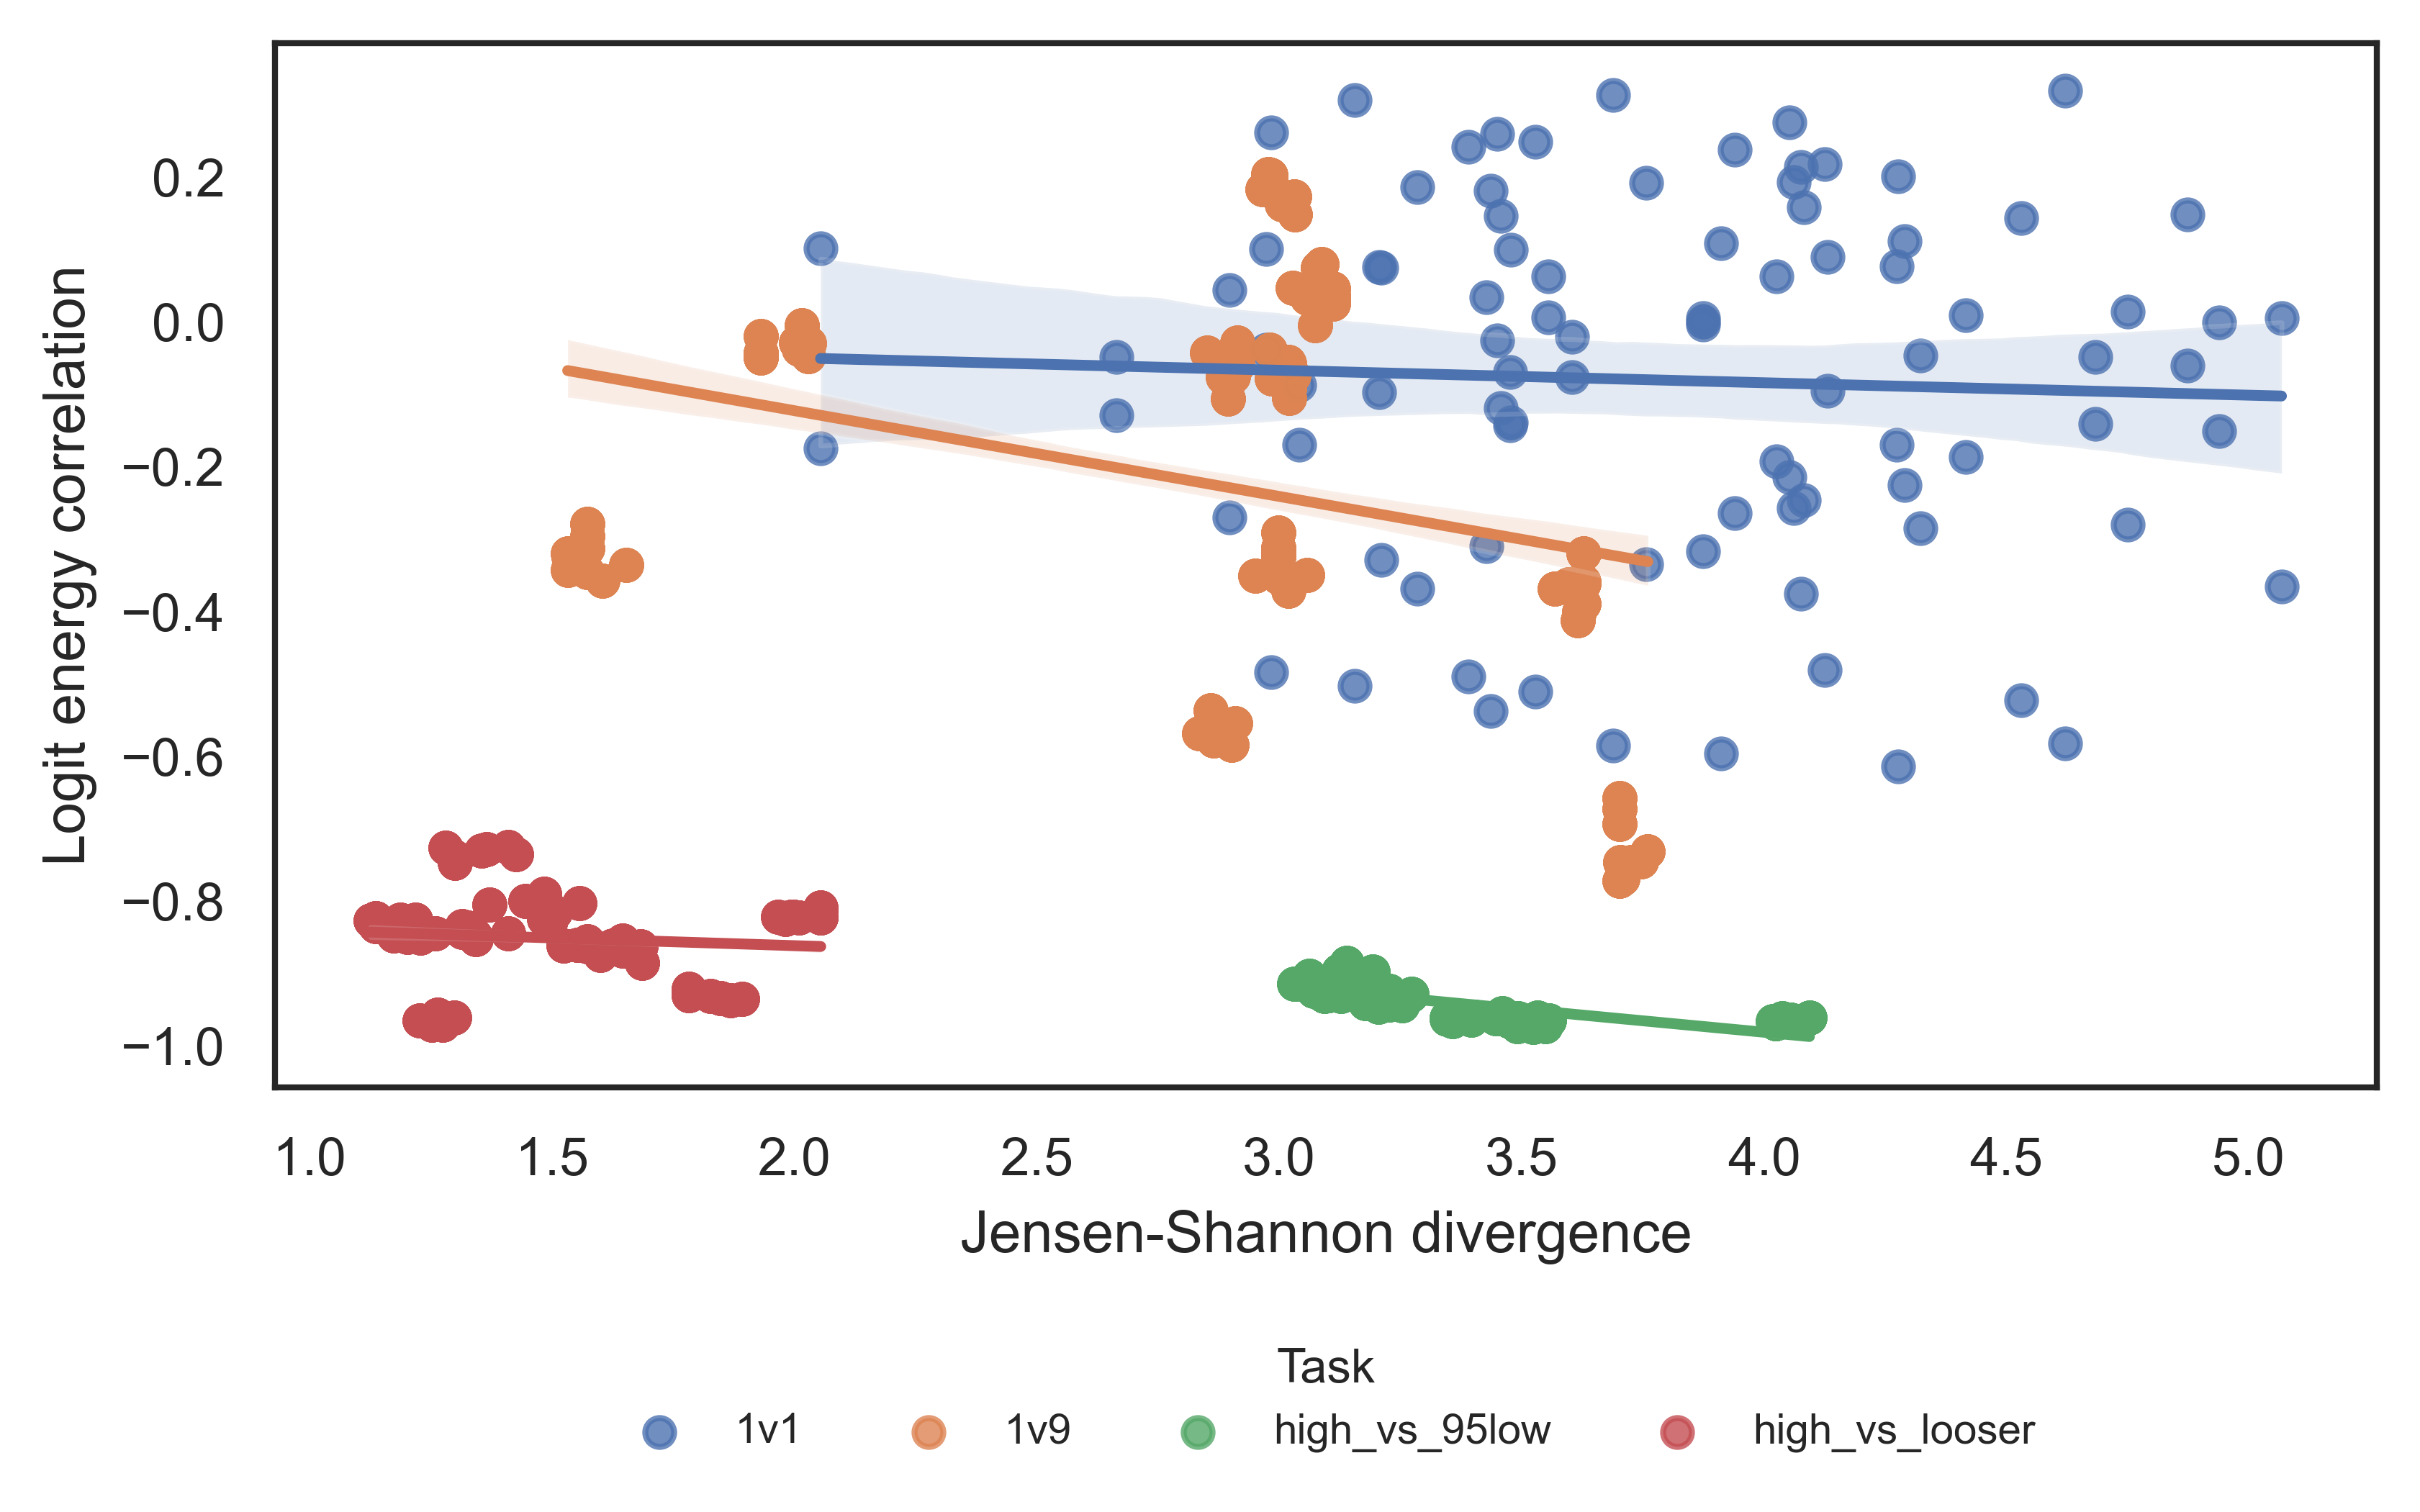

In [41]:
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
for i, df_g in df_merged.groupby("task_type"):
    sns.regplot(x="jsd", y="r", data=df_g, scatter=True, label=i, ax=ax)

ax.set_xlabel("Jensen-Shannon divergence")
ax.set_ylabel("Logit energy correlation")
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)





<Axes: xlabel='jsd', ylabel='r'>

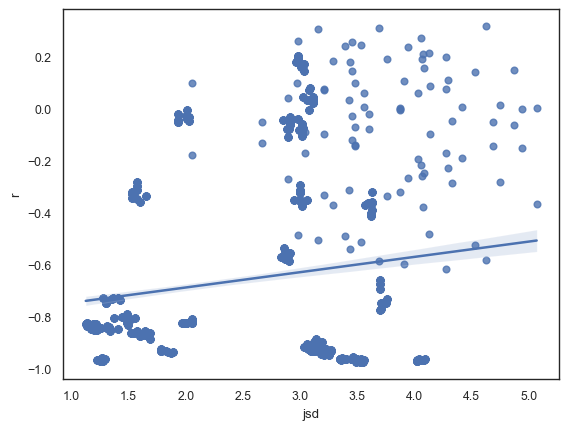

In [44]:
sns.regplot(x="jsd", y="r", data=df_merged)

### Eng of temp analysis

vs 1
vs 1: r=0.73, p=0.00
vs 9
vs 9: r=0.94, p=0.00
vs Non-binder
vs Non-binder: r=0.77, p=0.00
vs Weak
vs Weak: r=0.30, p=0.00


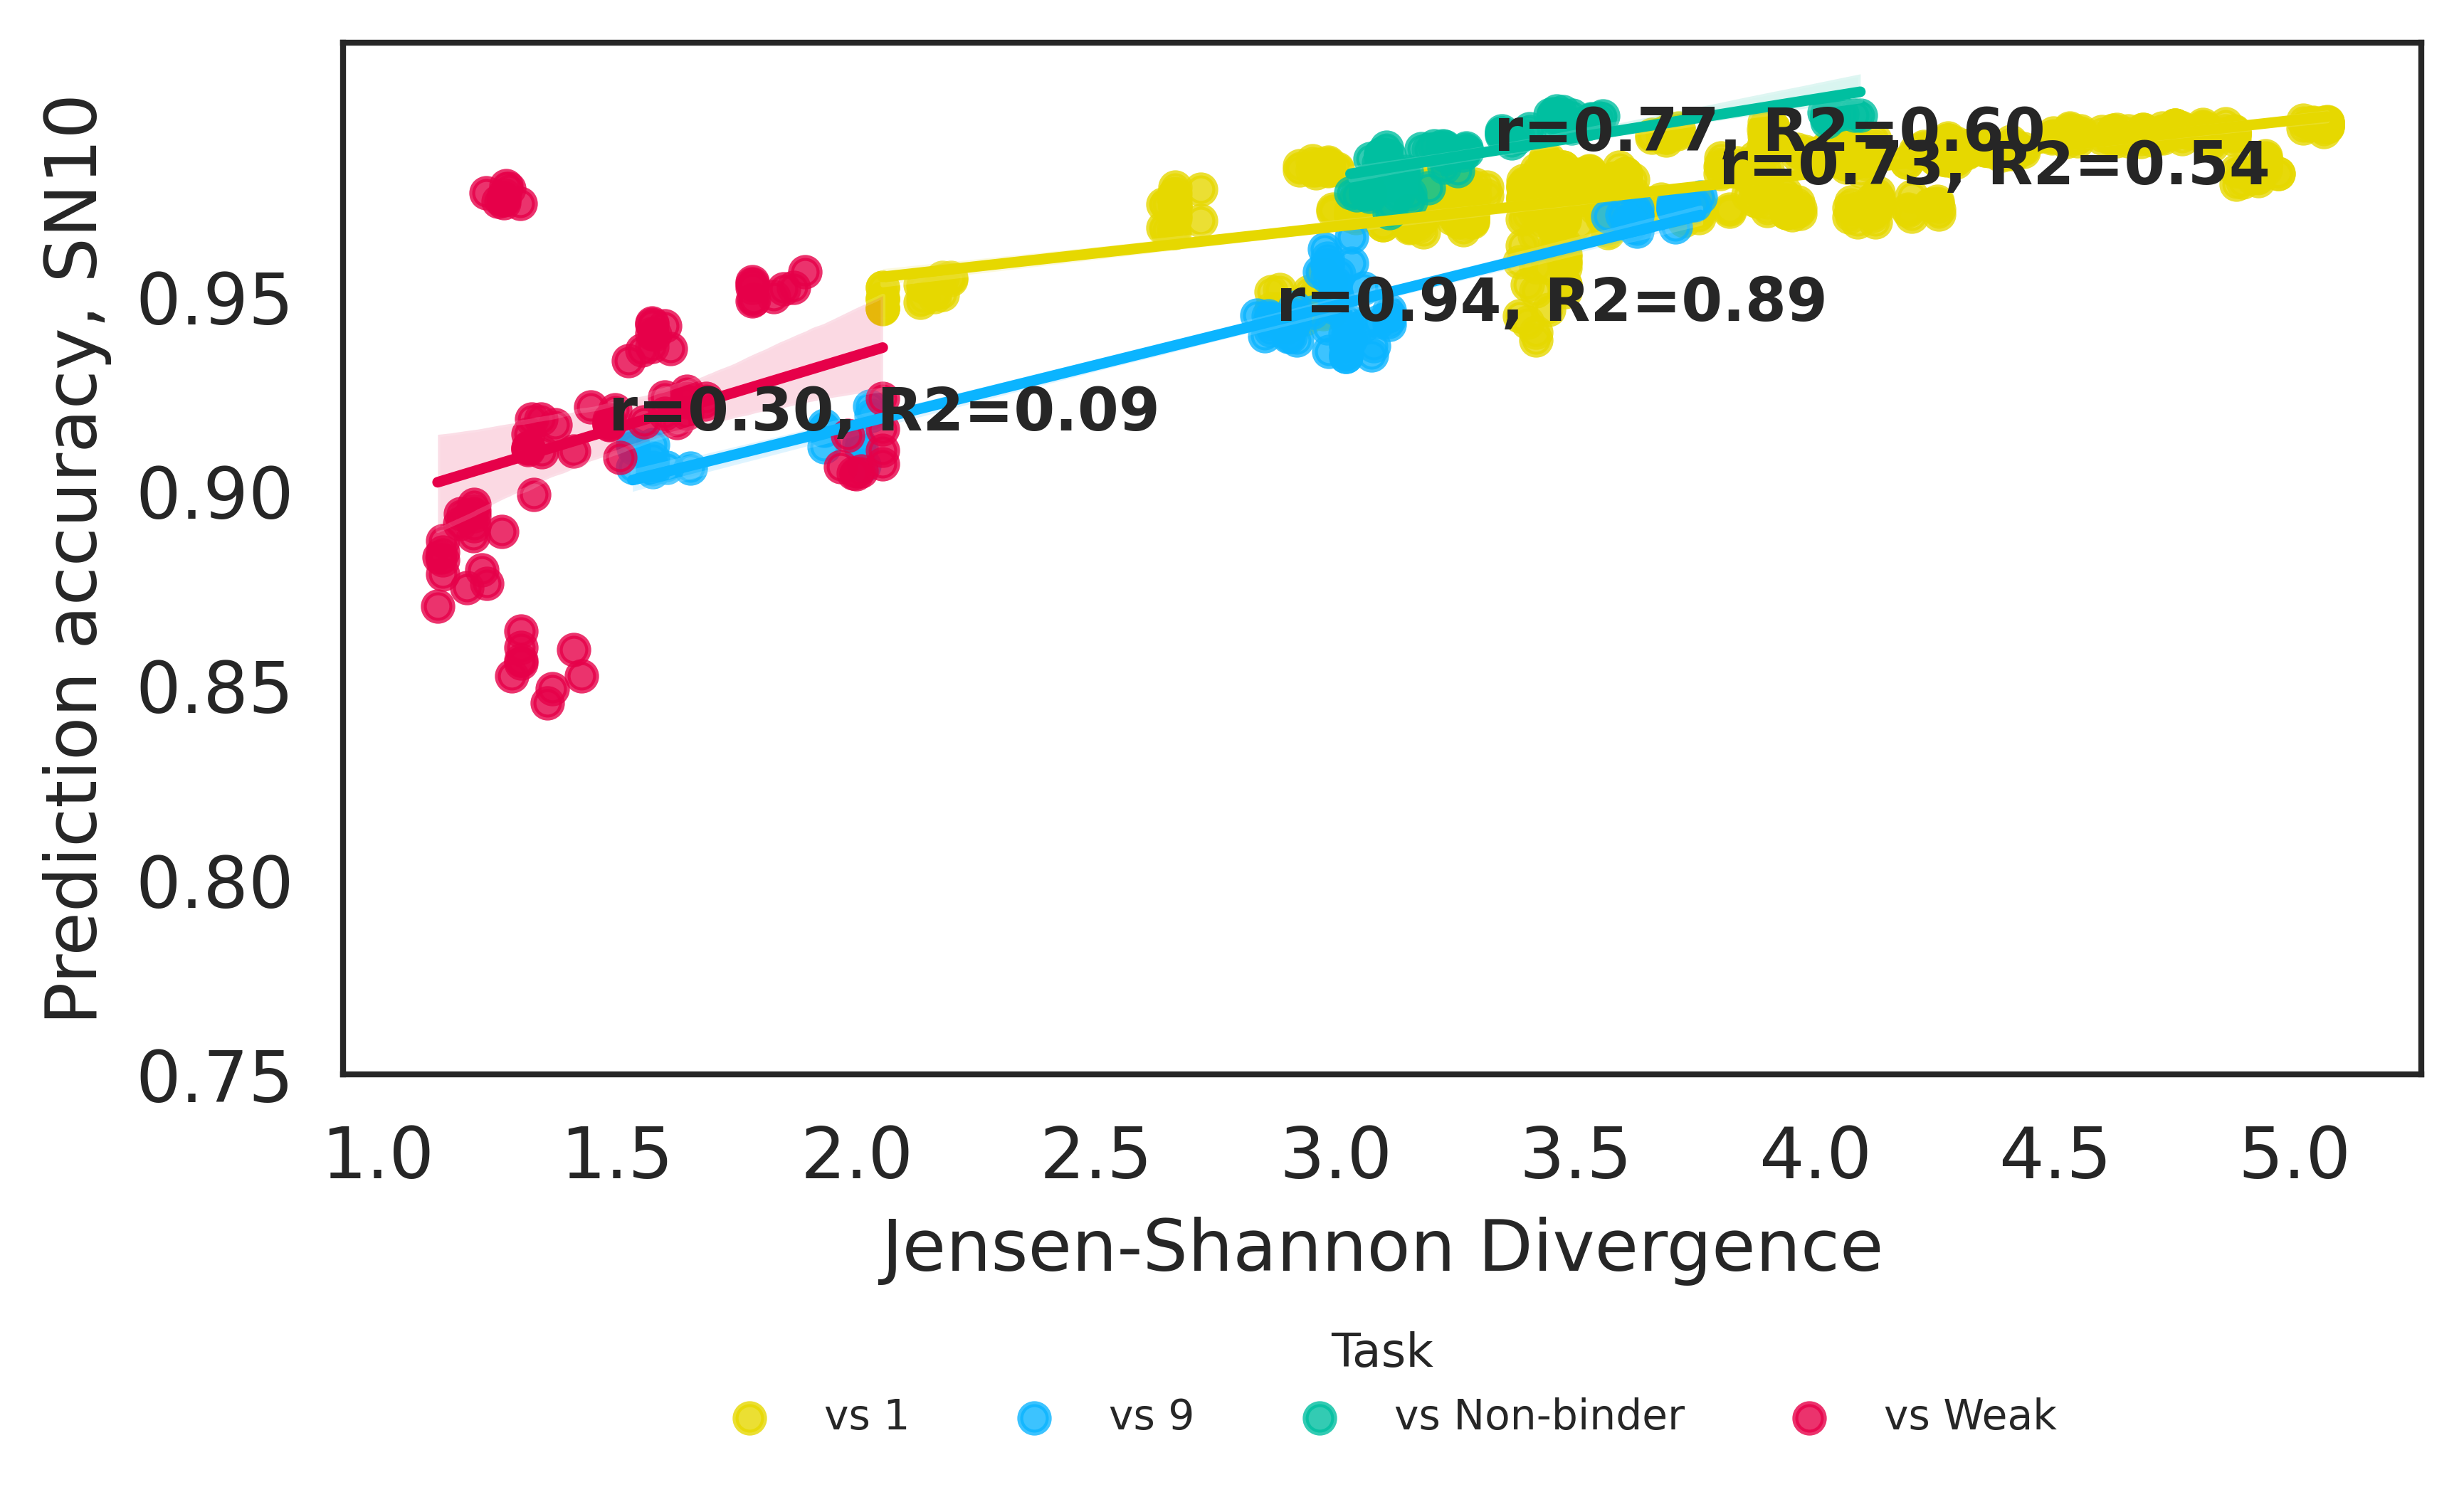

In [11]:
from scipy.stats import pearsonr

cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for i, df_g in df.groupby("task_type_clean"):
    print(i)
    color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
    sns.regplot(
        x="jsd",
        y="acc_closed",
        data=df_g,
        scatter=True,
        color=color,
        ax=ax,
        label=i,
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc_closed"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)

fig.show()

In [12]:
for i, df_g in df.groupby("task_type_clean"):
    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc_closed"])
    print(f"{i}: r={r:.2f}, p={pval:.2f}")

vs 1: r=0.73, p=0.00
vs 9: r=0.94, p=0.00
vs Non-binder: r=0.77, p=0.00
vs Weak: r=0.30, p=0.00


## OOD
Precomputation of openset performances (Table 1C) is done in the notebook 15b.

In [15]:
df_o = pd.read_csv(base_p / "openset_performance.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(116640, 10)


task_1                             task_2  \
0  HIGH_VS_95LOW__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__0__42   
1  HIGH_VS_95LOW__3VRL__auto__0__42  HIGH_VS_LOOSER__3VRL__auto__0__42   
2  HIGH_VS_95LOW__3VRL__auto__0__42     ONE_VS_NINE__3VRL__auto__0__42   
3  HIGH_VS_95LOW__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__1__42   
4  HIGH_VS_95LOW__3VRL__auto__0__42  HIGH_VS_LOOSER__3VRL__auto__1__42   

        acc  recall  precision        f1    ag    task_1_type     task_2_type  \
0  0.996600   0.998   0.995213  0.996605  3VRL  high_vs_95low   high_vs_95low   
1  0.758500   0.998   0.674780  0.805163  3VRL  high_vs_95low  high_vs_looser   
2  0.912356   0.998   0.852117  0.919307  3VRL  high_vs_95low             1v9   
3  0.996600   0.998   0.995213  0.996605  3VRL  high_vs_95low   high_vs_95low   
4  0.758500   0.998   0.674780  0.805163  3VRL  high_vs_95low  high_vs_looser   

  replicate_id  
0         0_42  
1         0_42  
2         0_42  
3         0_42  
4         0_42

In [16]:
df_o["model_task"] = df_o["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o["test_task"] = df_o["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

0 1FBI
1 3VRL
2 2YPV
3 5E94
4 1WEJ
5 1OB1
6 1NSN
7 1H0D
8 3RAJ
9 1ADQ


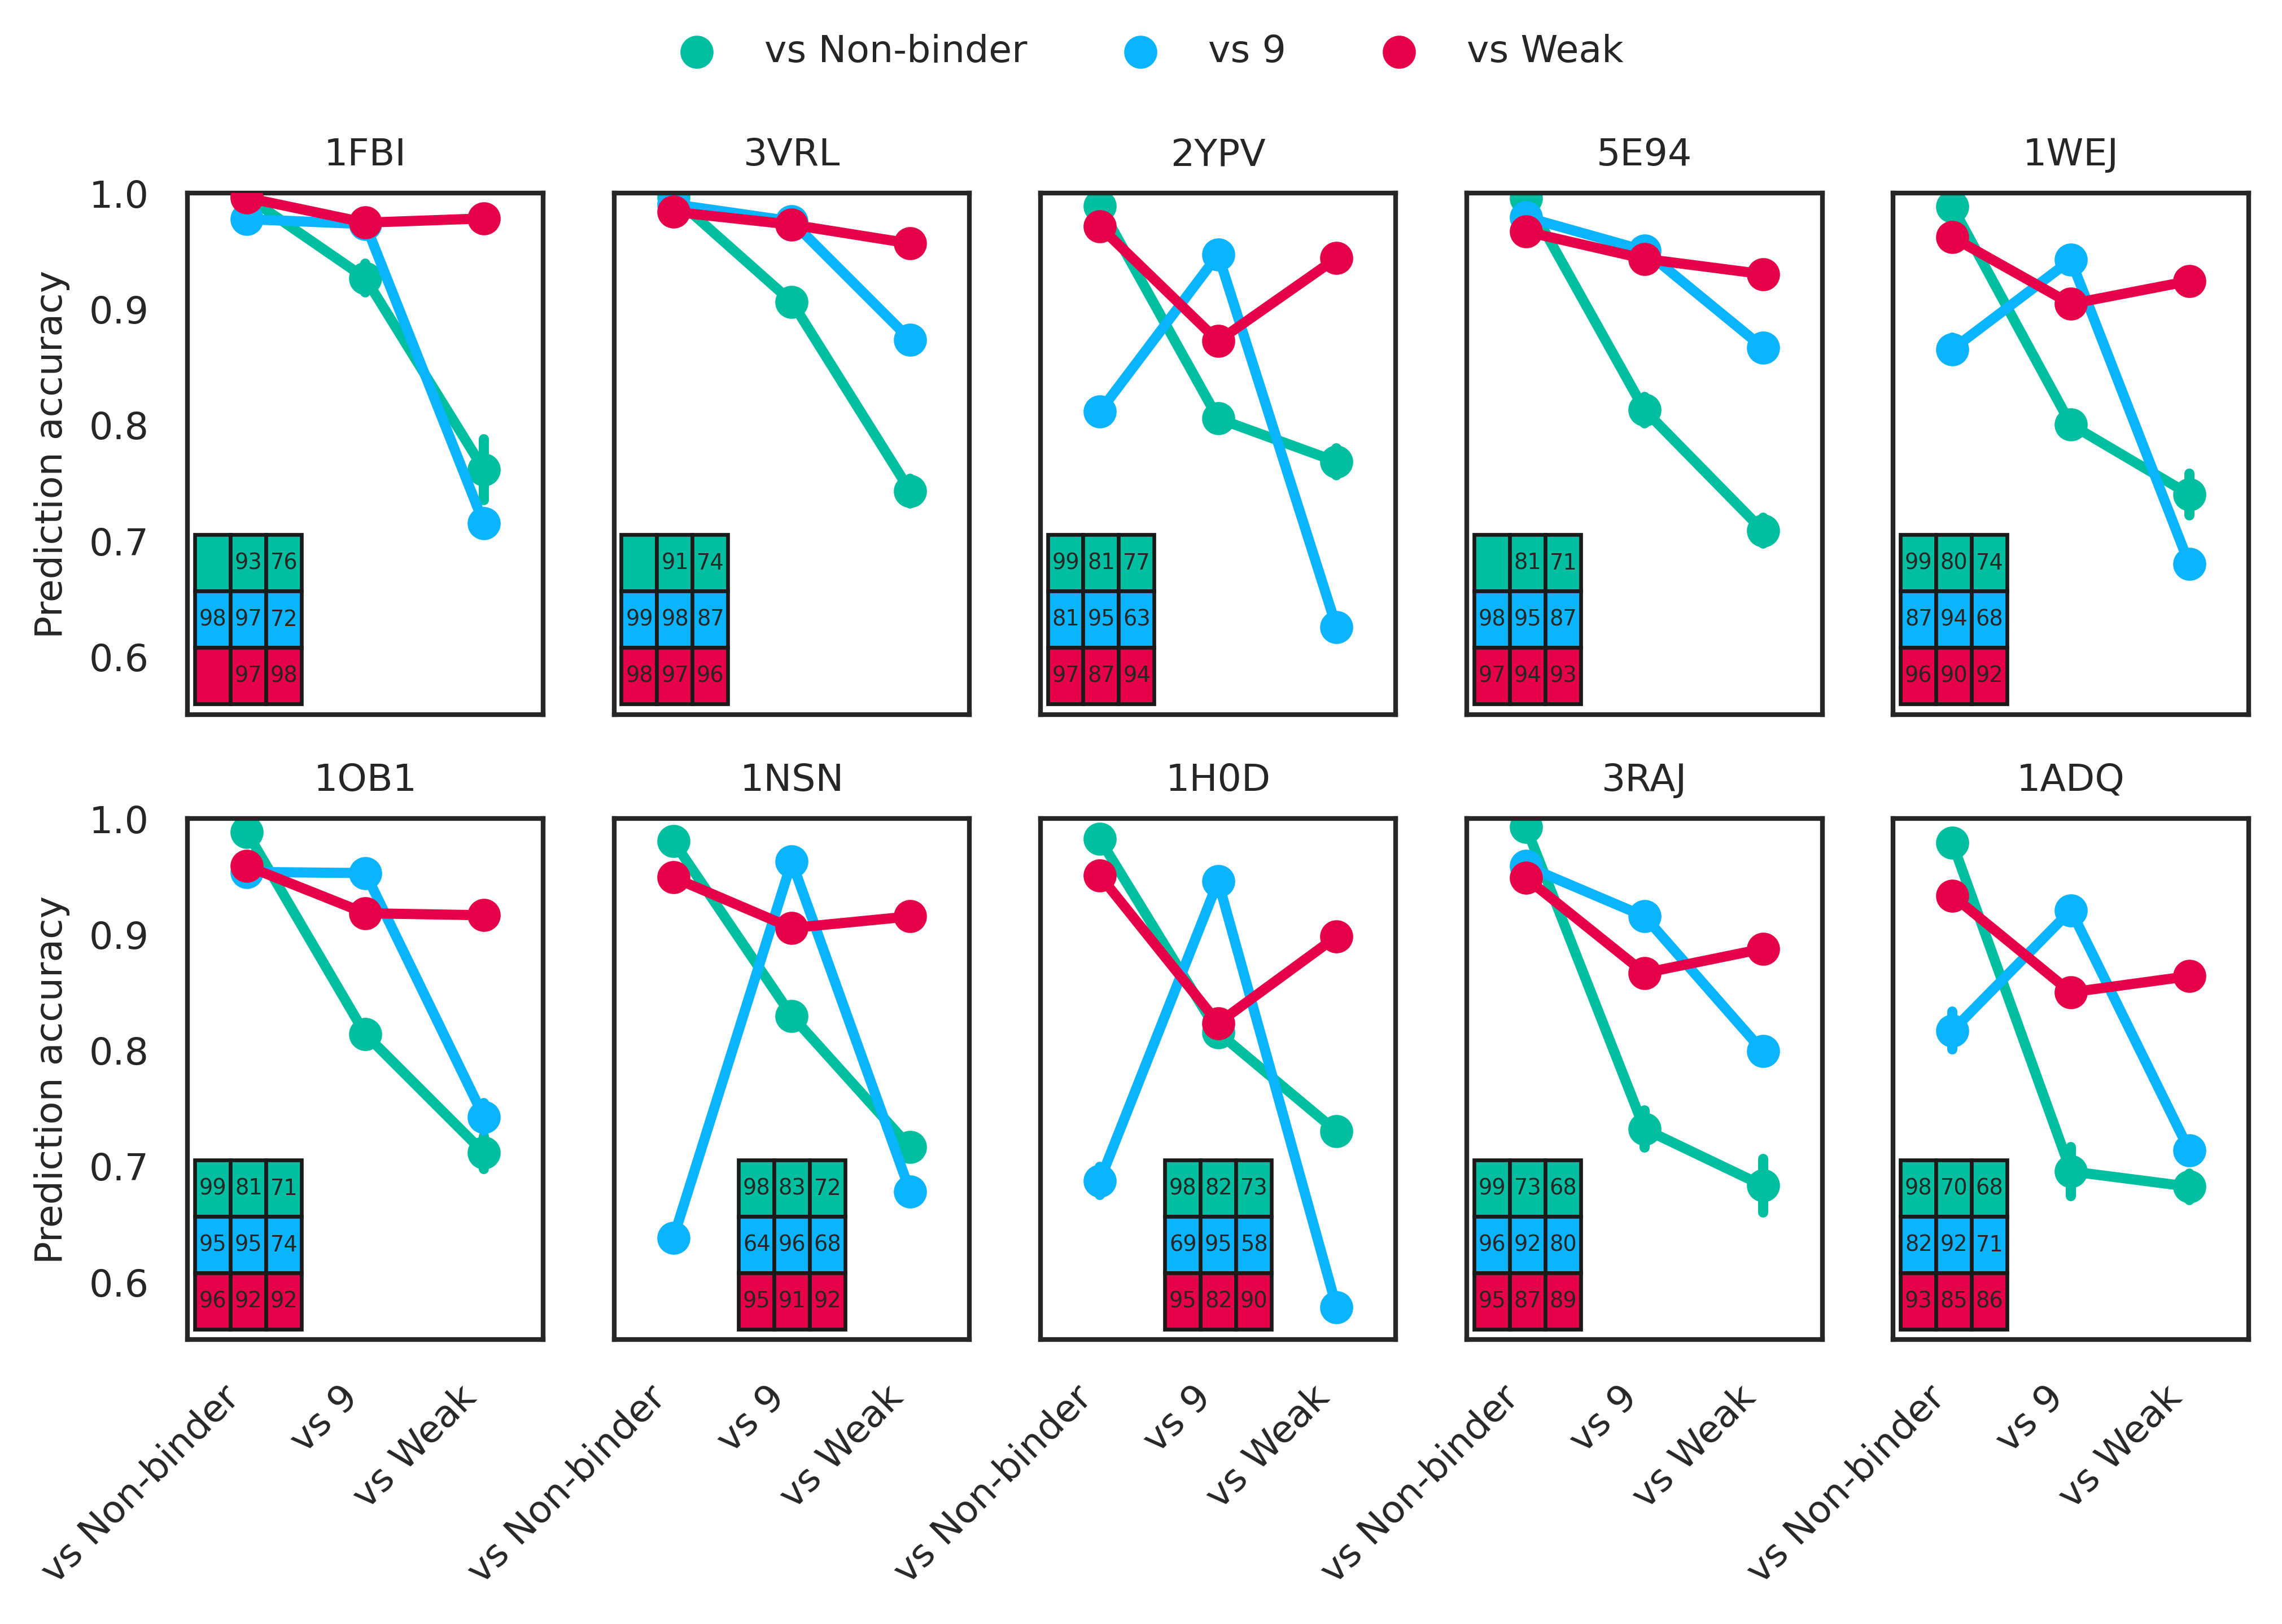

In [18]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

task_order = visualisations.PlotParams.order_tasks_clean.copy()
task_order.remove("vs 1")

for i, ag in enumerate(visualisations.PlotParams.order_antigens):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    df_i = df_o.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.55, 1.0)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

    # Tables inside the plot
    if row == 1 and col in [1, 2]:
        loc = "lower center"
    else:
        loc = "lower left"
    try:
        table_values = (
            df_i.groupby(["model_task", "test_task"])["acc"]
            .mean()
            .reset_index()
            .pivot(index="model_task", columns="test_task", values="acc")
            .loc[task_order][task_order]
            .values * 100).round().astype(int)
        table_values = np.where(table_values == 100, "", table_values)
        ax.table(
            cellText=table_values,
            loc=loc,
            colWidths=[0.1, 0.1, 0.1],
            cellColours=np.array([cmap for _ in range(3)]).transpose(),
        )
    except:
        pass

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

fig.show()

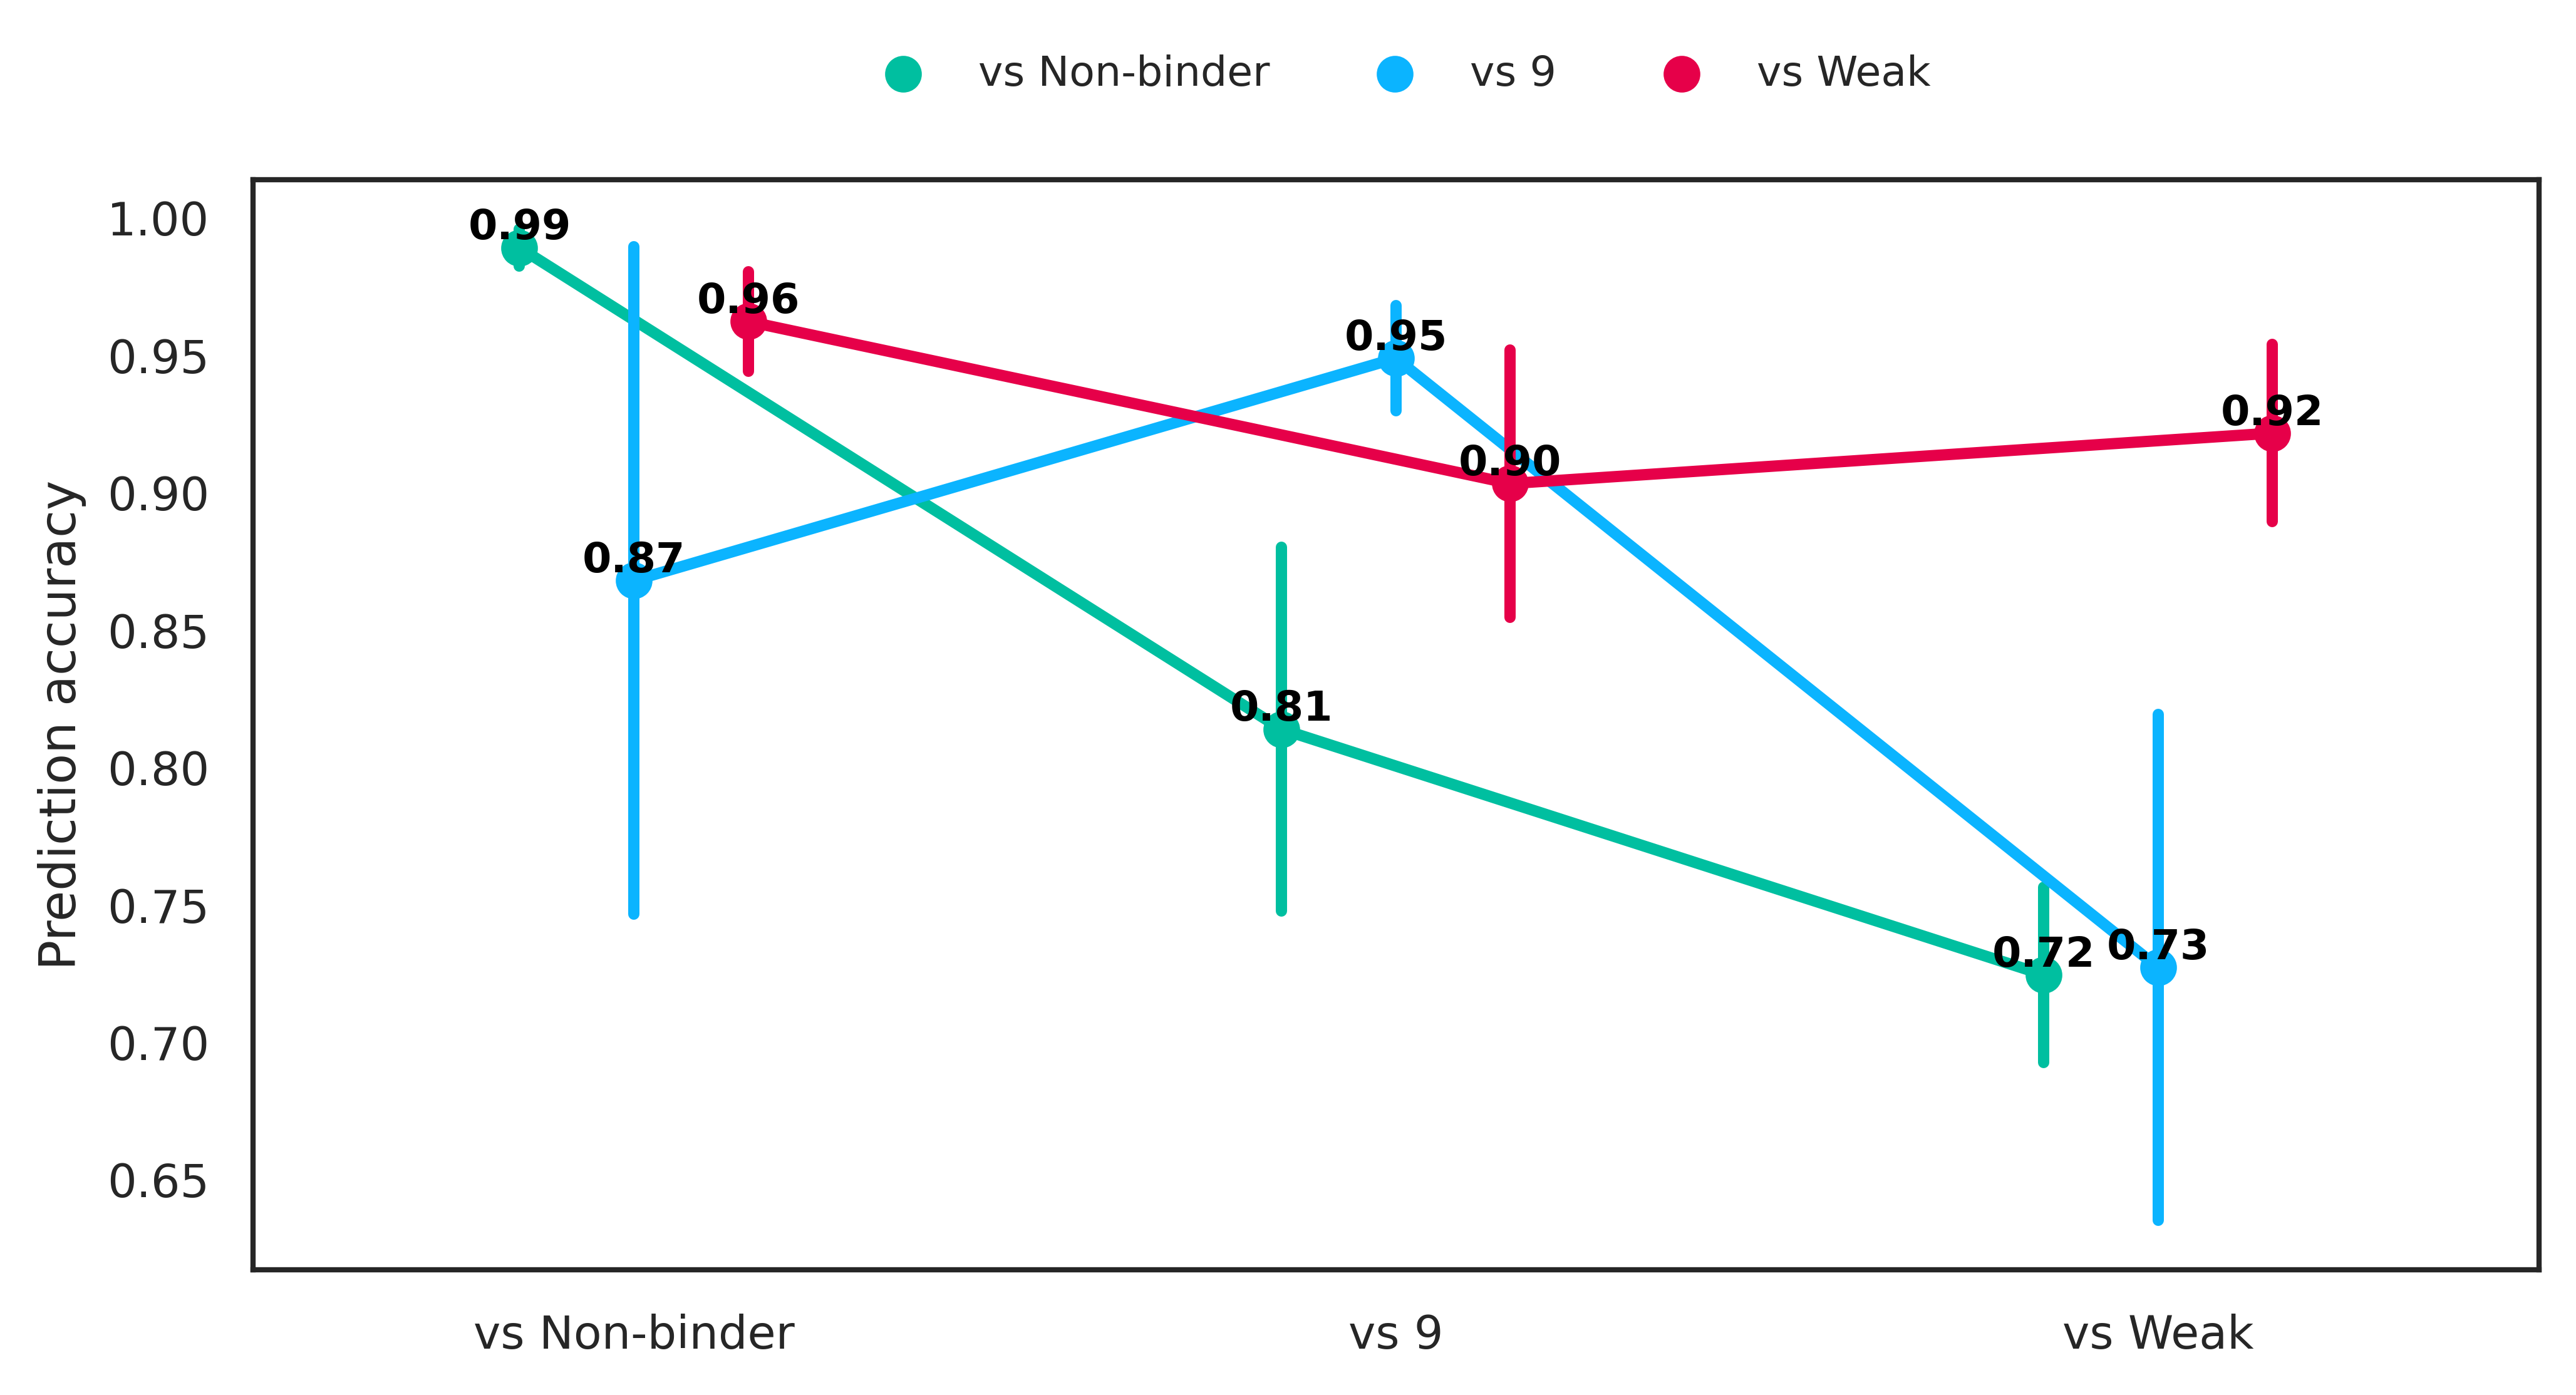

In [19]:
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    df_o,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order,
    hue="model_task",
    hue_order=task_order,
    palette=cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

fig.show()

In [20]:
df.groupby("task_type")[["acc", "jsd"]] \
    .agg(["mean", "std"]) \
    .round(2)

acc         jsd      
                mean   std  mean   std
task_type                             
1v1             0.98  0.01  3.80  0.64
1v9             0.94  0.02  2.87  0.62
high_vs_95low   0.99  0.01  3.33  0.28
high_vs_looser  0.92  0.03  1.48  0.27

## ID vs OOD

In [21]:
# Add in-distribution as separate column
df_o["is_indistribution"] = df_o["model_task"] == df_o["test_task"]
df_o_indistr = df_o.loc[df_o["is_indistribution"]].copy()
df_o = pd.merge(df_o, df_o_indistr[["task_1", "acc"]], on=["task_1"], suffixes=("", "_ID"))

df_o.head()

task_1                            task_2     acc  \
0  HIGH_VS_95LOW__3VRL__auto__0__42  HIGH_VS_95LOW__3VRL__auto__0__42  0.9966   
1  HIGH_VS_95LOW__3VRL__auto__0__42  HIGH_VS_95LOW__3VRL__auto__0__42  0.9966   
2  HIGH_VS_95LOW__3VRL__auto__0__42  HIGH_VS_95LOW__3VRL__auto__0__42  0.9966   
3  HIGH_VS_95LOW__3VRL__auto__0__42  HIGH_VS_95LOW__3VRL__auto__0__42  0.9966   
4  HIGH_VS_95LOW__3VRL__auto__0__42  HIGH_VS_95LOW__3VRL__auto__0__42  0.9966   

   recall  precision        f1    ag    task_1_type    task_2_type  \
0   0.998   0.995213  0.996605  3VRL  high_vs_95low  high_vs_95low   
1   0.998   0.995213  0.996605  3VRL  high_vs_95low  high_vs_95low   
2   0.998   0.995213  0.996605  3VRL  high_vs_95low  high_vs_95low   
3   0.998   0.995213  0.996605  3VRL  high_vs_95low  high_vs_95low   
4   0.998   0.995213  0.996605  3VRL  high_vs_95low  high_vs_95low   

  replicate_id     model_task      test_task  is_indistribution  acc_ID  
0         0_42  vs Non-binder  vs Non-binder               True  0.9966  
1         0_42  vs Non-binder  vs Non-binder               True  0.9966  
2         0_42  vs Non-binder  vs Non-binder               True  0.9966  
3         0_42  vs Non-binder  vs Non-binder               True  0.9966  
4         0_42  vs Non-binder  vs Non-binder               True  0.9977

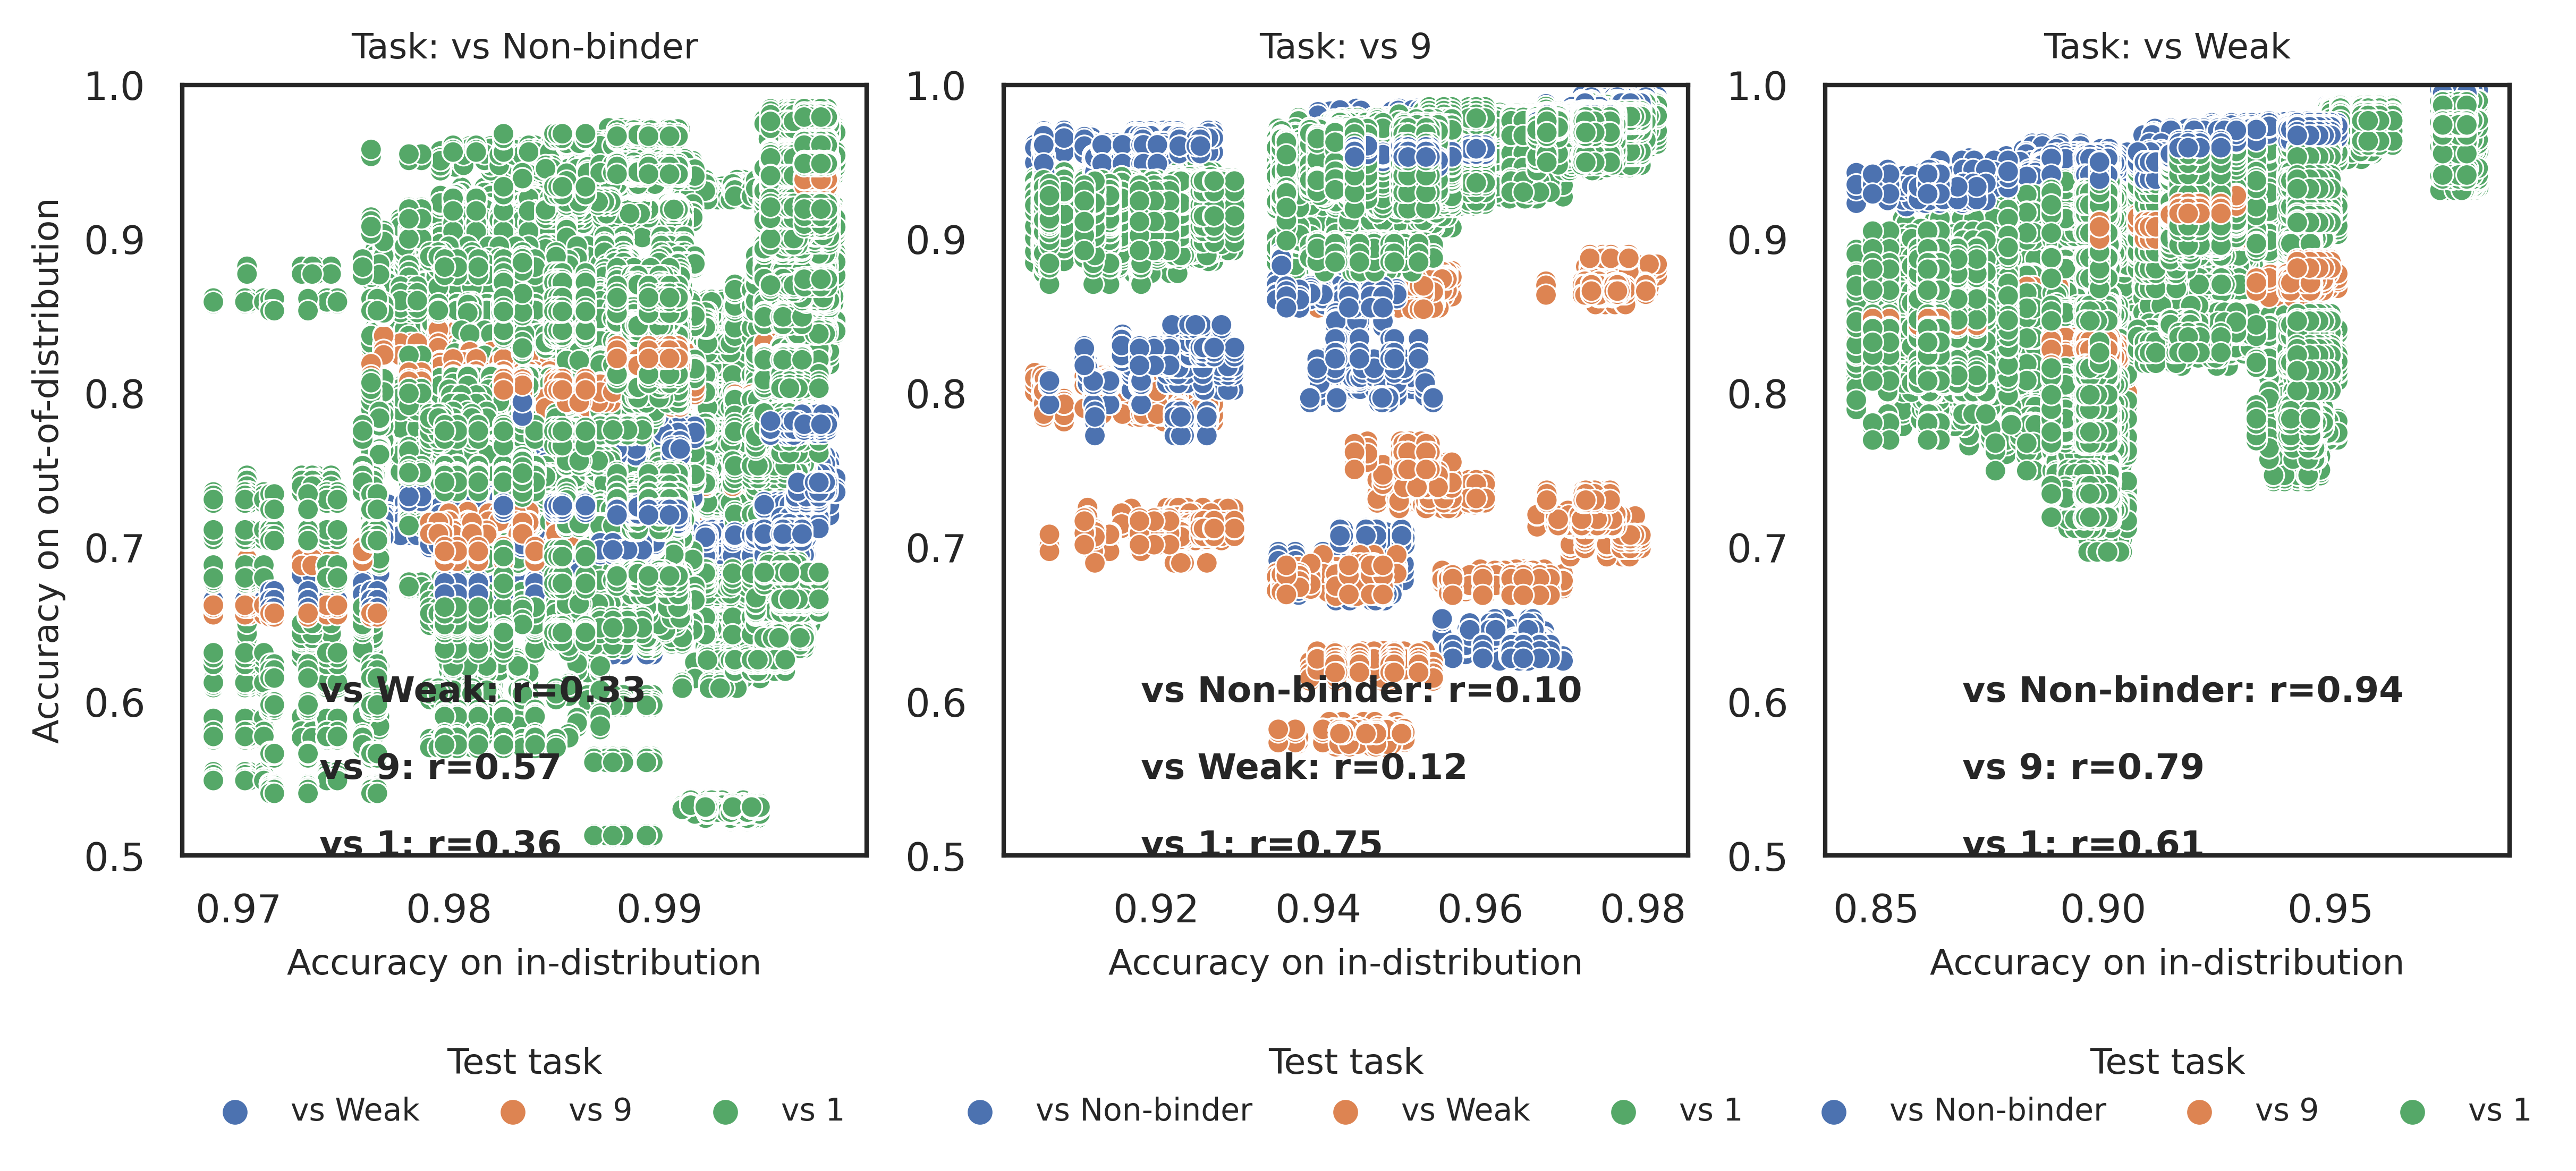

In [22]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3 * 3.14, 3.14), dpi=600)

task_order = visualisations.PlotParams.order_tasks_clean.copy()
task_order.remove("vs 1")

for i, task_i in enumerate(task_order):
    # row = 0
    col = i % 3
    ax = axs[col]
    df_i = df_o.query("model_task == @task_i").loc[~df_o["is_indistribution"]]
    sns.scatterplot(
        data=df_i,
        x="acc_ID",
        y="acc",
        hue="test_task",
        # pallette=cmap,
        ax=ax,
    )

    ax.set_title(f"Task: {task_i}", fontsize=8)
    ax.set_xlabel("Accuracy on in-distribution", fontsize=8)
    if col == 0:
        ax.set_ylabel("Accuracy on out-of-distribution", fontsize=8)
    else:
        ax.set_ylabel(None)
    # ax.set_xlim(0.8, 1.0)
    ax.set_ylim(0.5, 1.0)

    # Legend location under the plot
    ax.legend(
        bbox_to_anchor=(0.5, -0.3),
        loc="center",
        borderaxespad=0.0,
        fontsize=7,
        title="Test task",
        title_fontsize=8,
        ncol=10,
        frameon=False,
    )

    # Add correlation numbers in the plots
    # 2 numbers per plot, per test_task, 
    # with color corresponding to the plot hue
    for j, test_task in enumerate(df_i["test_task"].unique()):
        df_i_tt = df_i.query("test_task == @test_task")
        r, pval = pearsonr(df_i_tt["acc_ID"], df_i_tt["acc"])
        ax.text(
            0.2,
            0.2 - 0.1 * j,
            f"{test_task}: r={r:.2f}",
            fontsize=8,
            fontweight="bold",
            transform=ax.transAxes,
        )
    


In [23]:
df_o.to_csv(base_p / "openset_performance_ext.tsv", sep="\t", index=False)